In [1]:
import numpy as np
import tqdm as tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
from src.libs.preprocessing import DataLoader

In [3]:
# data path
small_data_set = False
if small_data_set:
    path_train_x = "data/input/denoising/train_small"
    path_train_y = "data/input/voice_origin/train_small"
else:
    path_train_x = "data/input/denoising/train"
    path_train_y = "data/input/voice_origin/train"

data_loader = DataLoader(path_x=path_train_x, path_y=path_train_y)
# need to normalize the data
harmonized_data = data_loader.get_harmonized_data(
    downsample=small_data_set
)  # True if train small, false otherwise
clean = True
if clean:
    n_reduction = 1000
    harmonized_data.x = harmonized_data.x[:n_reduction]
    harmonized_data.y = harmonized_data.y[:n_reduction]
    harmonized_data.names = harmonized_data.names[:n_reduction]
    harmonized_data.n_samples = n_reduction
    del data_loader

Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


In [4]:
harmonized_data.x.shape

(1000, 80000)

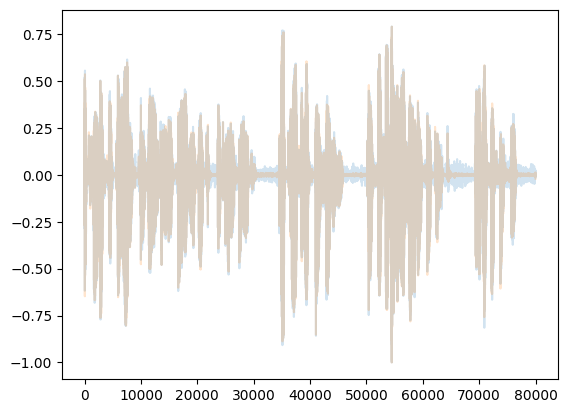

In [5]:
plt.plot(harmonized_data.x[1], alpha=0.2)
plt.plot(harmonized_data.y[1], alpha=0.2)

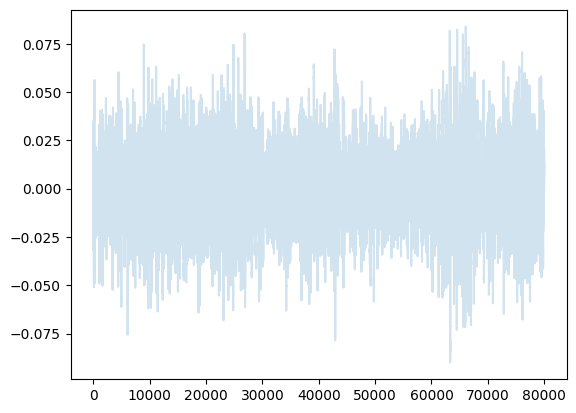

In [6]:
plt.plot(harmonized_data.x[1] - harmonized_data.y[1], alpha=0.2)

In [16]:
Audio(harmonized_data.y[8] - harmonized_data.x[8], rate=8000)

In [8]:
Audio(harmonized_data.y[1], rate=harmonized_data.sampling_freq)

In [32]:
import numpy as np
from scipy.signal import stft, istft
import matplotlib.pyplot as plt


def wiener_filter_single_signal(signal, sr, noise_segment=None, nperseg=1024):
    """
    Applique un filtre de Wiener pour débruiter un signal unique.

    Arguments :
    - signal : array NumPy contenant le signal bruité.
    - sr : fréquence d'échantillonnage (Hz).
    - noise_segment : portion du signal contenant uniquement du bruit (None si inconnu).
    - nperseg : taille de fenêtre pour la STFT.

    Retourne :
    - signal_filtered : signal débruité.
    """
    # Étape 1 : Estimer le spectre du bruit
    if noise_segment is None:
        # Si on n'a pas de bruit explicite, on estime un bruit faible par défaut
        noise_segment = signal[
            : sr // 2
        ]  # Par défaut, première demi-seconde comme bruit
    _, _, Zxx_bruit = stft(noise_segment, nperseg=nperseg)
    puissance_bruit = np.mean(np.abs(Zxx_bruit) ** 2, axis=1, keepdims=True)

    # Étape 2 : STFT du signal bruité
    f, t, Zxx_signal = stft(signal, nperseg=nperseg)

    # Étape 3 : Calcul du filtre de Wiener
    puissance_signal = np.abs(Zxx_signal) ** 2
    H_wiener = puissance_signal / (puissance_signal + puissance_bruit)

    # Étape 4 : Appliquer le filtre
    Zxx_filtered = H_wiener * Zxx_signal

    # Étape 5 : Reconstruction du signal via ISTFT
    _, signal_filtered = istft(Zxx_filtered, nperseg=nperseg)
    return signal_filtered


file_number = 6
# Exemple d'utilisation
signal_filtered = wiener_filter_single_signal(
    harmonized_data.x[file_number], harmonized_data.sampling_freq, nperseg=2**10
)

# Comparer les signaux
# plt.figure(figsize=(10, 6))
# plt.plot(signal, label="Signal Bruité", alpha=0.6)
# plt.plot(signal_filtered, label="Signal Filtré (Wiener)", alpha=0.8)
# plt.legend()
# plt.title("Comparaison entre Signal Bruité et Signal Filtré")
# plt.show()

In [33]:
thr = 0.15
signal_threshold = signal_filtered
signal_threshold[np.abs(signal_threshold) < thr] = 0

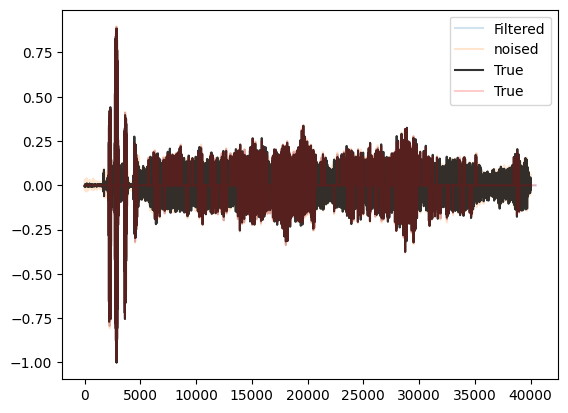

In [36]:
# plt.plot(harmonized_data.x[file_number], alpha=0.2)
plt.figure()
plt.plot(signal_filtered, alpha=0.2, label="Filtered")
plt.plot(harmonized_data.x[file_number], alpha=0.2, label="noised")
plt.plot(harmonized_data.y[file_number], alpha=0.8, label="True", color="black")
plt.plot(signal_threshold, alpha=0.2, label="True", color="red")
plt.legend()
plt.show()

In [11]:
# Audio(signal_filtered, rate=harmonized_data.sampling_freq)
Audio(harmonized_data.x[file_number], rate=harmonized_data.sampling_freq)

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    harmonized_data.x, harmonized_data.y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8, 40000) (2, 40000) (8, 40000) (2, 40000)


In [13]:
# mlp = MLPRegressor(
#     hidden_layer_sizes=(512, 512),
#     max_iter=200,
#     random_state=42,
#     verbose=True,
# )
# mlp.fit(X_train, y_train)

In [14]:
# X_test[0].shape

In [15]:
# file_number = 10
# pred_x = mlp.predict(X_test[[file_number]])[0]
# pred_x.shape

In [16]:
# plt.plot(pred_x, alpha=0.2)
# plt.plot(X_test[file_number], alpha=0.2)
# plt.show()

In [17]:
# Audio(pred_x, rate=harmonized_data.sampling_freq)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim


# # Modèle LSTM avec Convolution 1D
# class DenoisingLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(DenoisingLSTM, self).__init__()
#         self.conv1 = nn.Conv1d(
#             in_channels=1, out_channels=16, kernel_size=3, padding=1
#         )  # Conv pour extraire des features
#         self.relu = nn.ReLU()
#         self.lstm = nn.LSTM(
#             input_size=16,
#             hidden_size=hidden_size,
#             num_layers=2,
#             batch_first=True,
#             dropout=0.2,
#         )
#         self.fc = nn.Linear(
#             hidden_size, output_size
#         )  # Couche de sortie (1 caractéristique = signal débruité)

#     def forward(self, x):
#         # Ajouter une dimension de canal si nécessaire
#         x = x.unsqueeze(
#             1
#         )  # Transforme (batch, seq_len) -> (batch, channels=1, seq_len)

#         # Appliquer Conv1D pour extraire des caractéristiques
#         x = self.conv1(x)  # Convolution 1D attend (batch, channels, seq_len)
#         x = self.relu(x)

#         # Revenir en (batch, seq_len, features) pour le LSTM
#         x = x.permute(0, 2, 1)  # Réorganise les dimensions pour LSTM

#         # Passage dans LSTM
#         lstm_out, _ = self.lstm(x)

#         # Projection finale
#         output = self.fc(lstm_out)
#         return output


# # Paramètres du modèle
# input_size = 16  # Taille des caractéristiques après Conv1D
# hidden_size = 64
# output_size = 1

# model = DenoisingLSTM(input_size, hidden_size, output_size)

# # Fonction de perte et optimiseur
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# print(model)

In [ ]:
# # Préparation des données (Exemple)
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Signal bruité
# Y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Signal propre

# # Entraînement
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Passage avant
#     outputs = model(X_train_tensor)

#     # Calcul de la perte
#     loss = criterion(outputs, Y_train_tensor)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Affichage de la perte
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

In [ ]:
# # Exemple de prédiction sur une séquence d'entrée
# model.eval()  # Mode évaluation (pas de mise à jour des gradients)
# file_number = 20
# with torch.no_grad():
#     X_test_tensor = torch.tensor(
#         X_test[[file_number]], dtype=torch.float32
#     )  # X_test avec des séquences de taille variable
#     predictions = model(X_test_tensor)[0]

# # Affichage de la forme des prédictions
# print(predictions.shape)  # Forme : [batch_size, seq_len, output_size]
# plt.plot(X_test_tensor[0], alpha=0.2)
# plt.plot(predictions, alpha=0.2)
# plt.ylim(-1, 1)

In [ ]:
# X_test[[10]].shape, X_test[[file_number]].shape

In [ ]:
# X_test_tensor.shape